In [1]:
import iml_util
import numpy as np
import os

D = iml_util.gen_data_subject_0()

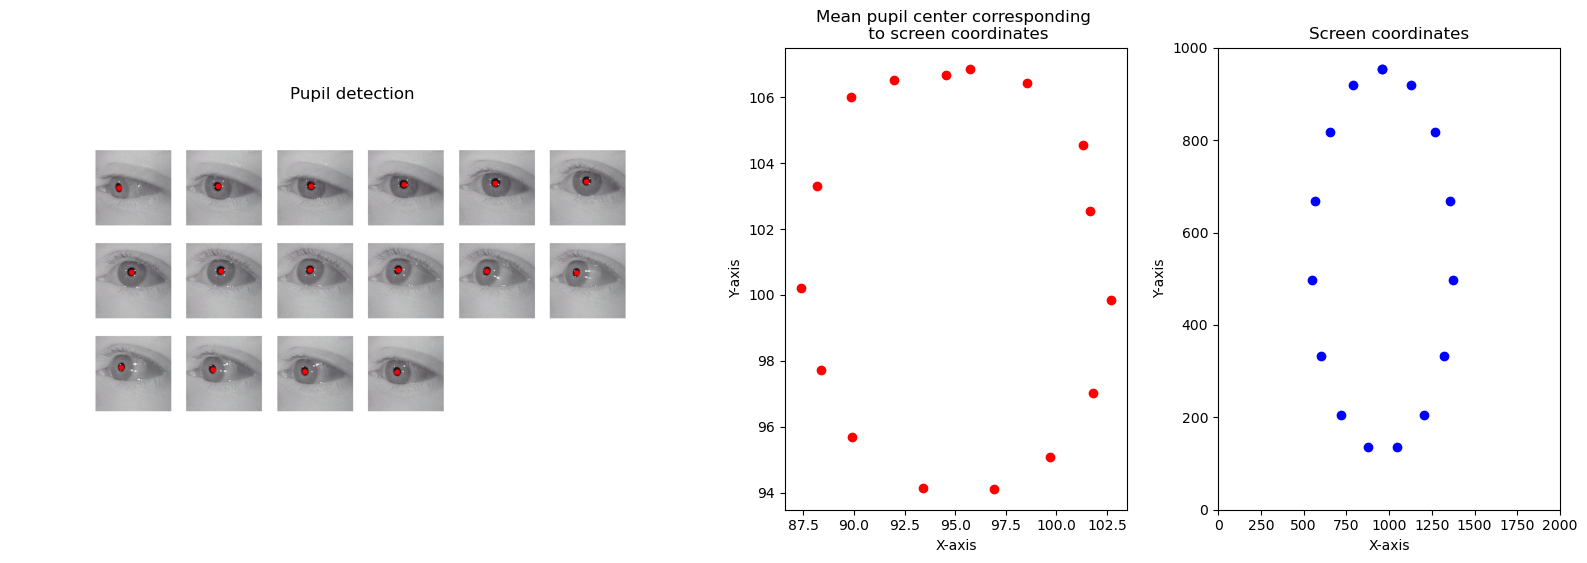

In [8]:
dataset = D[1] #change this index to show the different sessions

grid = iml_util.create_image_grid_viz(dataset)
iml_util.image_and_scatter(grid, dataset)

1. Describe the setup of the data collection was performed. Reflect on any pitfalls in the setup that may contribute to noisy data. What are the challenges of having multiple test subjects?

There were issues with aligning the computer screen with the level of the eyes of the test subject (Mads). The setup was a little unstable, because we had to place the computer on top of books so that the subject would be able to see the patterns while the camera was also close to their eyes. 

Paste the folder containing your data to the data/test_subjects folder.
Run the cell below to extract frames for test_person_3 .
Observe that the extracted frames will be placed in the output folder.
Important
Note that the output folder should only contain frames extracted from a single .mp4 file. Do not mix patterns and subjects into the same folder.
Update the variable folder_name to test_person_1 and rerun the cell.
Update the variable folder_name to your data and rerun the cell.
Update the folder_name and video_name to produce folders of frames for each test person for each pattern.

In [ ]:
# Extract frames from the video
folder_name = 'mads'
pattern = 'circle'
#trial = '20250901_T0'
#frame_folder =f"data/test_subjects/{folder_name}/{trial}/{pattern}/frames"
frame_folder =f"data/test_subjects/{folder_name}/{pattern}.mp4"


output_directory = f"data/output/{folder_name}/{pattern}"

if not os.path.isdir(output_directory):
    os.makedirs(output_directory, exist_ok=True)
    iml_util.extract_frames(frame_folder, output_directory)

Extracted 491 frames from data/test_subjects/test_subject_3/random.mp4 to data/output/test_subject_3/random


In [31]:
def pupil_detection(img, threshold_value, eye, debug, 
                    x_margin, y_margin, x_top, y_top, x_bot, y_bot, 
                    min_minor_axis=10, max_minor_axis=25, max_axis_ratio=2):
    """
    Returns (x, y) in original image coordinates, or None.
    Skips frames if no fitted ellipse passes axis-size and axis-ratio checks.
    """

    cv = iml_util.cv
    img_h, img_w = img.shape[:2]

    # --- 0) Clamp + expand box, then crop ---
    x1, y1 = x_top, y_top
    x2, y2 = x_bot, y_bot


    roi = img[y1:y2, x1:x2].copy()
    roi_color = cv.cvtColor(roi, cv.COLOR_GRAY2BGR)

    if debug:
        dbg_full = cv.cvtColor(img.copy(), cv.COLOR_GRAY2BGR)
        cv.rectangle(dbg_full, (x1, y1), (x2, y2), (0, 255, 0), 2)
        iml_util.show_image('Bounding Box', dbg_full)
        iml_util.show_image('ROI (cropped)', roi)

    # --- 1) Threshold -> 2) Edges -> 3) Contours ---
    _, thresh = cv.threshold(roi, threshold_value, 255, cv.THRESH_BINARY)
    edges = cv.Canny(thresh, 100, 200)
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if debug:
        roi_cnt = roi_color.copy()
        cv.drawContours(roi_cnt, contours, -1, (255, 0, 0), 1)
        iml_util.show_image('ROI Contours', roi_cnt)
        iml_util.show_image('ROI Threshold', thresh)
        iml_util.show_image('ROI Edges', edges)

    # --- 4) Evaluate contours (largest first) until one is valid ---
    valid = None
    for c in sorted(contours, key=len, reverse=True):
        print(len(c))
        if len(c) < 50:
            print("_____2")
            continue
        ellipse = cv.fitEllipse(c)  # ((cx,cy),(MA,ma), angle)
        (cx, cy), (a1, a2), ang = ellipse
        major, minor = (max(a1, a2), max(1e-6, min(a1, a2)))
        print(major, minor)
        ratio = major / minor

        if debug:
            print(f"[CAND] pts={len(c)} minor={minor:.2f} major={major:.2f} ratio={ratio:.2f}")

        if ratio > max_axis_ratio:
            print("_____4")
            continue

        valid = (ellipse, (cx, cy), major, minor, ratio)
        print(valid)
        break  # choose first valid candidate

    if valid is None:
        if debug:
            print("[SKIP] No contour passed size/ratio checks.")
        return None

    ellipse, (cx, cy), major, minor, ratio = valid
    center = (cx + x1, cy + y1)

    if debug:
        # ROI view with chosen ellipse and overlays
        roi_draw = roi_color.copy()
        cv.ellipse(roi_draw, ellipse, (255, 255, 255), 2)
        cv.circle(roi_draw, (int(cx), int(cy)), 4, (0, 0, 255), -1)
        cv.putText(roi_draw, f"min={minor:.1f} max={major:.1f} r={ratio:.2f}",
                   (5, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv.LINE_AA)
        iml_util.show_image('ROI: Chosen ellipse', roi_draw)

        # Full-image view with found pupil center
        full_draw = cv.cvtColor(img.copy(), cv.COLOR_GRAY2BGR)
        cv.circle(full_draw, (int(center[0]), int(center[1])), 5, (0, 0, 255), -1)
        iml_util.show_image('Full image: Pupil center', full_draw)

    return center if center != (0, 0) else None

In [33]:
# Main function to process the video and detect centroids
def process_frames(output_directory, frames_folder, threshold_value, debug=False, x_margin=20, y_margin=20):
    """
    Detect pupil centers, and create image grids.

    Parameters:
        output_directory (str): The directory where extracted frames and output data will be saved.
        threshold_value (int): The threshold value for binarizing images during pupil detection.
        side (str): Indicates which side of the image to process ('left' or 'right'). Default is 'left'.
        debug (bool): If True, debug information and images will be displayed. Default is False.
        x_margin (int): The horizontal margin for cropping the eye region. Default is 40.
        y_margin (int): The vertical margin for cropping the eye region. Default is 20.

    Returns:
        None
    """
    
    # Load the extracted eye images
    eye_images = iml_util.load_images_from_folder(frames_folder)
    
    # Detect centroids in the images and store results in a DataFrame
    centers = []
    data = []
    valid_images = []  # To store images where centers are found
    valid_centers = []  # To store corresponding centers
    invalid_images = []  # To store images where centers are not found

    for image_file, img in eye_images:
        #left, right = iml_util.split_img(img)
        img = iml_util.split_img(np.array(img))

        center = pupil_detection(np.array(img), threshold_value, 'l', debug, x_margin, y_margin, 250, 175, 375, 275)
            
        if center:
            centers.append(center)
            valid_images.append((image_file, img))  # Store valid images
            valid_centers.append(center)  # Store corresponding centers
            data.append({"image": image_file, "px": center[0], "py": center[1]})
        else:
            centers.append(None)  # Ensure centers list is the same length as images
            invalid_images.append((image_file, img))  # Store invalid images
    
    # Create a pandas DataFrame
    df = iml_util.pd.DataFrame(data)
    df.to_csv(iml_util.os.path.join(output_directory, "pupil_coordinates.csv"), index=False)
    
    # Generate a 10x10 grid of images with pupil centers drawn
    iml_util.create_image_grid(eye_images, centers, output_directory, grid_name='pupil_centers_grid')
    
    # the following line displays the first 100 images. Uncomment to display images 0 to 100. Change the interval to show desired images.
    #iml_util.create_image_grid(eye_images[0:100], centers, output_directory, grid_name='pupil_centers_grid') 

    if debug:
        # DEBUG: Generate the grid of images where centers were not found, limited to 10x10
        iml_util.create_image_grid(invalid_images, [None]*len(invalid_images), output_directory,grid_name='invalid_pupil_centers_grid', max_images=100)
    
    # Print results
    print(f"Total frames processed: {len(eye_images)}")
    print(f"Number of detected centers: {len([c for c in centers if c is not None])}")
    print(f"Pupil coordinates saved to {iml_util.os.path.join(output_directory, 'pupil_coordinates.csv')}")

# Experiment with parameter values
threshold_value = 50
x_margin = 40
y_margin = 20
debug = True  # Set to True to see the debugging steps

#print(frame_folder)

process_frames("data/output/mads/circle","data/test_subjects/mads/20250901_T0/circle/frames", 
               threshold_value, debug, x_margin, y_margin)

error: OpenCV(4.12.0) /Users/runner/miniforge3/conda-bld/libopencv_1756075613336/work/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
